# Introduction

## Business Problem


<u>**Predicting Uber/Lyft Prices**</u>  
Our goal is to evaluate the most significant factors that impact Uber/Lyft prices. 

We will be using Pandas, Matplotlib and Seaborn libraries to plot and analyze the data.

## Details on the data

The data was downloaded from Kaggle: https://www.kaggle.com/ravi72munde/uber-lyft-cab-prices?select=cab_rides.csv.

It was generated by Ravi Munde, who collected real-time data using Uber&Lyft api queries and corresponding weather conditions.
   
We will use two datasets:  
1) Weather Data: Dataset containing information about weather in Boston during 3 weeks in '2018.  
2) Rides Data: Dataset containing information about Uber/Lyft trips taken in Boston’s busy locations during those 3 weeks.  
  
<br>
<u> Weather Data: </u>
Each row represents a location in Boston at particular time, and corresponsing weather data. Each column in the table is described below.

* **location**  : Location in Boston where data about the weather was collected
* **time_stamp**  : Date-time (in epoch timestamp)
* **temp**  : Temperature of location in Fahrenheit 
* **clouds**  : Cloud information (0: no cloud, 1: heavy cloud)
* **pressure**  : Pressure at the location in pressure sea level (mb)
* **rain**  : Rain at the location 
* **humidity**  : Humidity at the location (in percentage)
* **wind**  : Wind-speed at the location (in mph)  
  
<u> Ride Data: </u>
Each row represents a ride taken in Boston in Uber or Lyft. Each column in the table is described below.

*	**id**  :	Unique ID for each ride
*	**cab_type**  :	Cab-type- Lyft or Uber
*	**time_stamp**  : Date-time of the ride-start (in epoch timestamp)
*	**source**  :	Pick-up location
*	**destination**  : Drop-off location
*	**distance**  :	Distance covered from pick-up to drop-location (in miles)
*	**price**  :	$ price of the ride
*	**surge_multiplier**  :	Multiplier of the regular price during surge times
*	**product_id**  :	Product-type of the ride
*	**name**  : Commonly known product description of the ride-type at Uber & Lyft

<br> 
**Basic Summary**:  
  
<u> Weather Data: </u>
* 6,276 rows
* There are 8 columns with 8 features

<u> Ride Data: </u>
* 693,071 rows
* There are 10 columns with 8 features
* 55,095 rows have missing values.


# Data Load & Processing

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
drive.mount('/content/gdrive')

cab_rides = pd.read_csv('/content/gdrive/Shared drives/IS833 Project/Datasets/cab_rides.csv')
weather = pd.read_csv('/content/gdrive/Shared drives/IS833 Project/Datasets/weather.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


First, we examine the rides dataframe.

In [119]:
cab_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   distance          693071 non-null  float64
 1   cab_type          693071 non-null  object 
 2   time_stamp        693071 non-null  int64  
 3   destination       693071 non-null  object 
 4   source            693071 non-null  object 
 5   price             637976 non-null  float64
 6   surge_multiplier  693071 non-null  float64
 7   id                693071 non-null  object 
 8   product_id        693071 non-null  object 
 9   name              693071 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 52.9+ MB


We have 55,095 rows with null values in the "price" column - all for the type ('name') "Taxi". We drop them because we can't use those records with information about the price.

In [120]:
cab_rides.dropna(inplace = True)

Then we look at the weather dataframe.

In [121]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        6276 non-null   float64
 1   location    6276 non-null   object 
 2   clouds      6276 non-null   float64
 3   pressure    6276 non-null   float64
 4   rain        894 non-null    float64
 5   time_stamp  6276 non-null   int64  
 6   humidity    6276 non-null   float64
 7   wind        6276 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 392.4+ KB


Weather dataframe has 5,382 missing values in the "rain" column. Given that values in this column signify rain in inches, we want to do an investigation for data with NaN rain.

In [122]:
print("Total records: ", weather.location.count())
print("Records with rain= 0: ", sum(weather.rain ==0))
print("Records with rain as NaN: ", sum(weather['rain'].isnull()))

Total records:  6276
Records with rain= 0:  0
Records with rain as NaN:  5382


For the records with valid rain information, we want to assess how rain and humidity are interrelated. We divide the data in 10 deciles based on the quantity of  rain and then plot the average humidity for those 10 rain buckets.

In [123]:
decile = ["Decile 01", "Decile 02", "Decile 03", "Decile 04", "Decile 05", "Decile 06", "Decile 07", "Decile 08", "Decile 09", "Decile 10"]
weather['rain_group'] = pd.qcut(weather['rain'], 10, labels = decile)

In [124]:
weather_rain_avgHumid = weather.groupby("rain_group").agg({'humidity': 'mean', 
                                                           'location': 'count'})
weather_rain_avgHumid.columns = ['AvgHumidity', 'Rows']
weather_rain_avgHumid.reset_index(inplace=True)
weather_rain_avgHumid

,rain_group,AvgHumidity,Rows
0,Decile 01,0.742088,91
1,Decile 02,0.829205,88
2,Decile 03,0.844674,92
3,Decile 04,0.910674,89
4,Decile 05,0.895287,87
5,Decile 06,0.898947,95
6,Decile 07,0.878929,84
7,Decile 08,0.861236,89
8,Decile 09,0.892584,89
9,Decile 10,0.893000,90


In [125]:
weather.groupby("rain_group").agg({'rain': 'max'})

,rain
rain_group,
Decile 01,0.0029
Decile 02,0.0031
Decile 03,0.0059
Decile 04,0.0093
Decile 05,0.0148
Decile 06,0.0260
Decile 07,0.0373
Decile 08,0.1130
Decile 09,0.1786


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

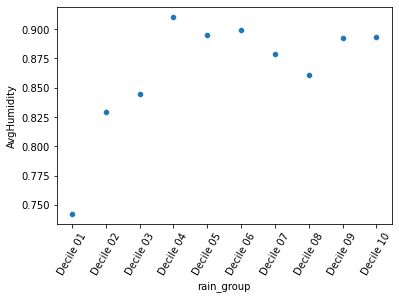

In [126]:
sns.scatterplot(x= "rain_group", y = "AvgHumidity" ,data = weather_rain_avgHumid)
plt.xticks(rotation = 60)

Above chart shows that as rain increases the average humidity also increases.

We then observe that for the data with 'NaN' rain, the  humidity values are further lower compared to data with positive rain value, both in terms of the mean as well as the IQR.

In [127]:
print("Mean humidity of records with NaN rain data: " ,  round(weather[weather['rain'].isnull()].humidity.mean(),2))
print("IQR humidity of records with NaN rain data: (" ,  weather[weather['rain'].isnull()].humidity.quantile(0.25),",", weather[weather['rain'].isnull()].humidity.quantile(0.75), ")")
print("")
print("Mean humidity of records with positive rain data: " ,  round(weather[~weather['rain'].isnull()].humidity.mean(),2))
print("IQR humidity of records with positive rain data: (" ,  weather[~weather['rain'].isnull()].humidity.quantile(0.25),",", weather[~weather['rain'].isnull()].humidity.quantile(0.75), ")")

Mean humidity of records with NaN rain data:  0.75
IQR humidity of records with NaN rain data: ( 0.66 , 0.85 )

Mean humidity of records with positive rain data:  0.86
IQR humidity of records with positive rain data: ( 0.86 , 0.92 )


Hence, we can say that 'NaN' rain data means 0 rain. Hence we will impute accordingly.

In [128]:
weather.drop(['rain_group'], axis = 1, inplace = True)
weather['rain'].fillna(0,inplace=True)
weather.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


Next, we extract date and time for from timestamp fields into new columns for both rides and weather dataframes.

In [129]:
cab_rides['date_time'] = pd.to_datetime(cab_rides['time_stamp']/1000, unit = 's')
cab_rides['date'] = pd.to_datetime(cab_rides['date_time'].dt.date)
cab_rides['hour'] = cab_rides['date_time'].dt.time.astype('str')
cab_rides['hour'] = cab_rides['hour'].str[:2]
cab_rides['day'] =  cab_rides['date_time'].dt.strftime('%A')

In [130]:
weather['date_time'] = pd.to_datetime(weather['time_stamp'], unit = 's')
weather['date'] = pd.to_datetime(weather['date_time'].dt.date)
weather['hour'] = weather['date_time'].dt.time.astype('str')
weather['hour'] = weather['hour'].str[:2]

We add a "price per mile" column to analyze how price for trips differs between types of cabs, times of the day, days of the week, etc. Recent legislation has set the base fee for ridesharing services at 40 cents for carpool rides and $1.20 for individual rides ([StreetsBlog Mass, 6 Jan 2021](https://mass.streetsblog.org/2021/01/06/final-bond-bill-sets-20-cent-transit-access-fee-for-uber-lyft-rides/#:~:text=Current%20fees%20for%20Uber%20and,and%20%241.20%20for%20individual%20rides.)). Thus, we are subtracting the base fee from the final price and dividing it by distance.

In [131]:
cab_rides['price_per_mile'] = (cab_rides['price'] - 1.20) / cab_rides['distance']
cab_rides.loc[cab_rides['name'] == 'Shared', 'price_per_mile'] = (cab_rides['price'] - 0.40) / cab_rides['distance']
cab_rides.loc[cab_rides['name'] == 'UberPool', 'price_per_mile'] = (cab_rides['price'] - 0.40) / cab_rides['distance']

# Data Exploration using Visualization

We start by looking at how the number of rides changes by the day of week. Based on the graph, the most popular day for rides is Tuesday, closely followed by Monday. Interestingly enough, weekdays tend to be more popular for than weekends.

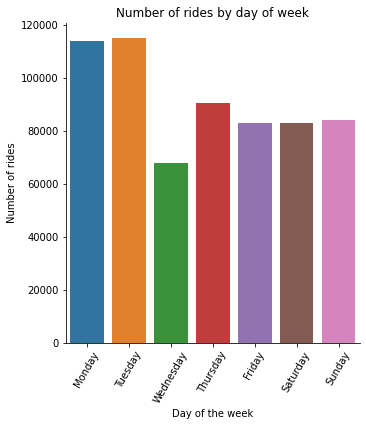

In [132]:
#Plotting the number of rides by day of week

day_vs_rides = cab_rides.groupby('day').agg({'id':'count'}).reset_index()
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.catplot(x = 'day', y = 'id', data = day_vs_rides, kind = 'bar', order = weekdays)
plt.xlabel('Day of the week')
plt.ylabel('Number of rides')
plt.title('Number of rides by day of week')
plt.xticks(rotation = 60);

Next, we plot the number of rides requested at the specific time of day. As we can see, the number of rides fluctuates significantly throughout the day, however between 10 AM and 5PM it is relatively stable.

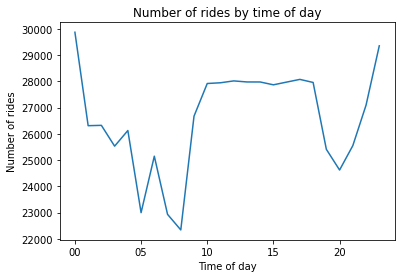

In [133]:
#Plotting the number of rides by hour

hour_vs_rides = cab_rides.groupby('hour').agg({'id':'count'}).sort_values(by = 'hour', ascending = True)
hour_vs_rides.plot(kind = 'line', legend = None)
plt.xlabel('Time of day')
plt.ylabel('Number of rides')
plt.title('Number of rides by time of day');

The plots below show how the price changes with the time of the day for each day of the week. For weekdays, usually the price peaks for the morning hours and for the weekend it is the opposite, the price peaks for the late evening hours. The price surge could be attributed to the many reasons. 
1. Increase in demand leading to decrease in supply. 
2. Average time to cover a mile in the peak morning or late evening traffic is higher compared to when the roads are not congested. 
3. Due to limited number of drivers during the weekends reduces the supply and that results in high prices.

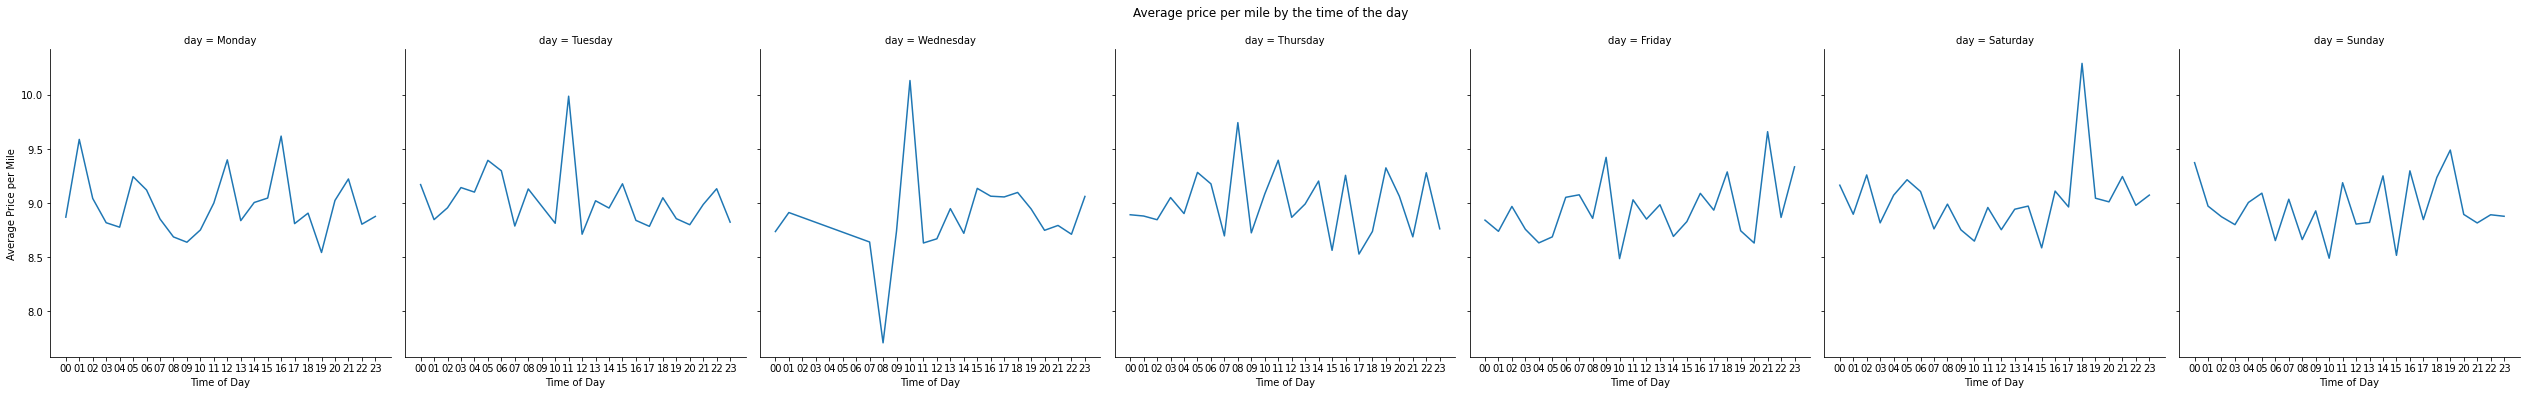

In [134]:
#Plotting the average price per mile by time of day

from pandas.api.types import CategoricalDtype
day_type = CategoricalDtype(categories=weekdays, ordered=True)
cab_rides['day'] = cab_rides['day'].astype(day_type)
price_vs_hour = cab_rides.groupby(['day','hour']).agg({'price_per_mile':'mean'}).sort_values(by = 'hour' , ascending = True)
a= sns.relplot(x = 'hour', y = 'price_per_mile', data = price_vs_hour, col = 'day', kind = 'line', style_order= 'day', size_order='day')
a.set(xlabel="Time of Day", ylabel="Average Price per Mile")
a.fig.suptitle("Average price per mile by the time of the day", y=1.05);

Below are two plots showing how average price per mile changes based on the type of cab service. Here are a few observations: 
1. Price fluctuation is much higher for Uber than Lyft. The pattern is visible across all types. 
2. The average price per mile for the shared / pool vehicles is the lowest and is not greatly affected by the time of the day. 
3. Uber's Black SUV and Lyft Black XL cost the most per mile to the customers.

Text(0.5, 1.02, 'Average price per mile for Uber')

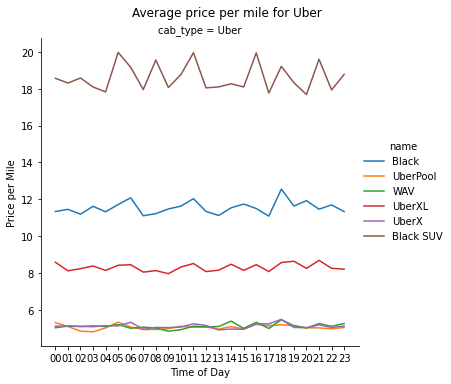

In [135]:
#Plotting the price per mile by type of service as Uber

cab_rides_Uber = cab_rides[cab_rides.cab_type=="Uber"]
price_vs_name_u = cab_rides_Uber.groupby(['cab_type','name','hour']).agg({'price_per_mile':'mean'}).sort_values(by = 'hour', ascending = True)
h=sns.relplot(x = 'hour', y = 'price_per_mile', hue = 'name', col = 'cab_type', data = price_vs_name_u , kind='line', legend = 'full', ci = 'sd');
h.set(xlabel="Time of Day", 
       ylabel="Price per Mile")
h.fig.suptitle("Average price per mile for Uber", y=1.02)

Text(0.5, 1.02, 'Average price per mile for Lyft')

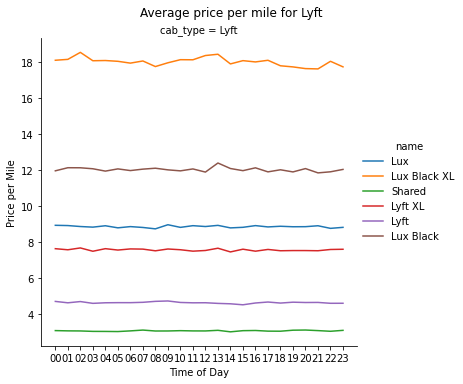

In [136]:
#Plotting the price per mile by type of service as Lyft

cab_rides_lyft = cab_rides[cab_rides.cab_type=="Lyft"]
price_vs_name_l = cab_rides_lyft.groupby(['cab_type','name','hour']).agg({'price_per_mile':'mean'}).sort_values(by = 'hour', ascending = True)
g=sns.relplot(x = 'hour', y = 'price_per_mile', hue = 'name', col = 'cab_type', data = price_vs_name_l, kind = 'line', legend= 'auto' );
g.set(xlabel="Time of Day", 
       ylabel="Price per Mile")
g.fig.suptitle("Average price per mile for Lyft", y=1.02)

Then we look at the distribution between surge and non surge rides. We observe that most of the rides (~97%) taken during the day are not affected by surge.

Surge 3.29 %
NoSurge 96.71 %


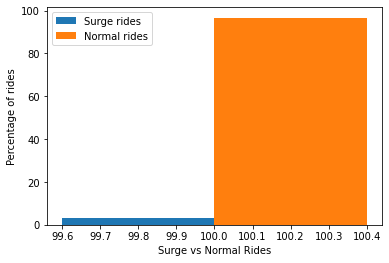

In [137]:
cab_rides[cab_rides['surge_multiplier']==1].shape[0]/cab_rides.shape[0]

Surge=(1-cab_rides[cab_rides['surge_multiplier']==1].shape[0]/cab_rides.shape[0])*100
Surge

NoSurge=100-Surge

print("Surge",round(Surge,2),"%")
print("NoSurge",round(NoSurge,2),"%")

label = ['Surge Rides','Normal']
X=[1,2]
  
X_axis = 100
  
plt.bar(X_axis - 0.2, Surge, 0.4, label = 'Surge rides')
plt.bar(X_axis + 0.2, NoSurge, 0.4, label = 'Normal rides')

#plt.bar(X_axis, Surge, 0.4, label = 'Surge rides')
#plt.bar(X_axis, NoSurge, 0.4, label = 'Normal rides')
  
#plt.xticks(X,label)
plt.xlabel("Surge vs Normal Rides")
plt.ylabel("Percentage of rides")
plt.title("")
plt.legend()
plt.show()

Now we want to examine the relationship between price per mile and the source where the trip started. We only have data for rides from 12 locations in Boston. The graph shows that there is some variability in price based on the source, with the most "expensive" one being Haymarket Square. North and South Stations and Financial District are in middle-priced, which is contrary to what we expected (expected them to be among the highest priced).

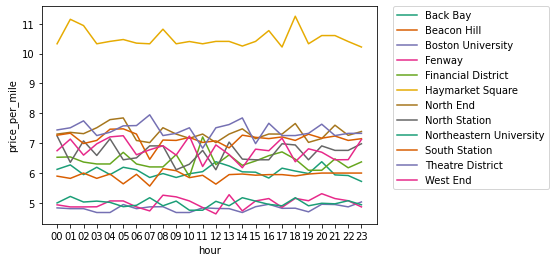

In [138]:
rides_Uber = cab_rides[cab_rides['cab_type'] == 'Uber']
source_vs_price = rides_Uber.groupby(['source','hour']).agg({'price_per_mile':'median'})
sns.lineplot(x = 'hour', y = 'price_per_mile', data = source_vs_price, hue = 'source', palette = 'Dark2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Here is the same graph for the destinations and it looks like the destination does affect pricing with Beacon Hill and Haymarket Square being the most "expensive" destinations.

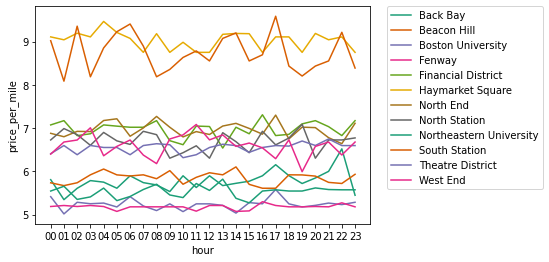

In [139]:
destination_vs_price = rides_Uber.groupby(['destination','hour']).agg({'price_per_mile':'median'})
sns.lineplot(x = 'hour', y = 'price_per_mile', data = destination_vs_price, hue = 'destination', palette = 'Dark2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

We also examined the data for Lyft and noticed roughly the same patterns for Lyft rides. The same locations come at the top for sources and destinations, but there is a lot more variability in terms of prices for other locations.

# Clustering

Instead of looking at all 6 variables in the "weather" dataset separately, we decided to cluster them using KMeans.

But first, we decided to plot the points to determine if there are any apparent clusters.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


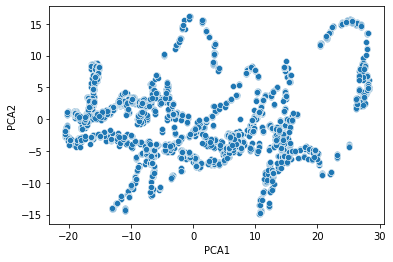

In [140]:
#Performing the dimensionality reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=2)        
X_weather = weather.drop(['location', 'time_stamp', 'date_time', 'date', 'hour'], axis = 1)
pca.fit(X_weather)
X_2D = pca.transform(X_weather)
X_weather['PCA1'] = X_2D[:, 0]
X_weather['PCA2'] = X_2D[:, 1]
sns.scatterplot("PCA1", "PCA2", data=X_weather);

There are certain groups of points that are clearly separate from the rest, thus we decided to check how the algorithm clusters the data.

In [141]:
from sklearn.cluster import KMeans  
kmeans = KMeans(n_clusters=4, random_state=833)
kmeans.fit(X_weather)                 
y_kmeans = kmeans.predict(X_weather) 
weather['cluster'] = y_kmeans

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


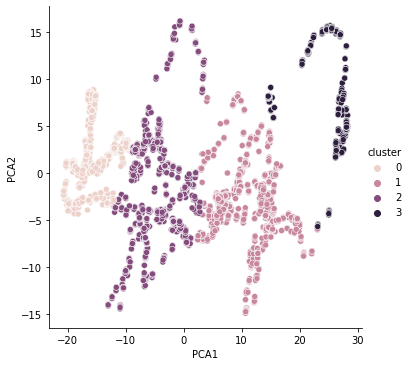

In [142]:
#Plotting the clusters
X_weather['cluster'] = y_kmeans
sns.relplot("PCA1", "PCA2", data=X_weather, hue='cluster');

The optimal number of clusters turned out to be 4. The clusters we ended up with are:

**Cluster 0** - little rain and very cloudy, medium pressure, high humidity, almost no wind

**Cluster 1** - little rain  cloudy, low pressure, high humidity, windy

**Cluster 2** - no rain and clear sky, low temperature, high pressure, medium humidity, almost no wind

**Cluster 3** - rainy, very cloudy and very windy, higher temperature, medium pressure, medium humidity

# Merging the datasets

We used "left" join to match the records from the "cab_rides" dataframe with the corresponding data about the weather using the source, date and hour.

Then we removed duplicates and the columns that we now longer need.

For some of the records (around 2,700 of them) there was no matching weather data, thus removed those records from the table.

In [143]:
merged = pd.merge(cab_rides, weather, left_on = ['source','date','hour'], right_on = ['location','date','hour'], how = 'left')
merged.drop_duplicates(subset = 'id', inplace = True)
merged.drop(['time_stamp_x','time_stamp_y', 'location', 'date_time_x', 'date_time_y'], axis = 1, inplace = True)
merged.dropna(inplace = True)
merged.head(1)

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,date,hour,day,price_per_mile,temp,clouds,pressure,rain,humidity,wind,cluster
0,0.44,Lyft,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16,09,Sunday,10.454545,38.46,0.29,1022.25,0.0,0.76,7.68,1.0


For our analysis, we need to add additional columns:

'Surge' with values 1 or 0, when there is surge or no surge respectively.

'Weekday' with values 1 or 0, indicating if the day is a weekday. 

'Day_time' with values "morning", "afternoon", "evening" and "night".

In [144]:
merged.loc[merged['surge_multiplier'] == 1.0, 'surge'] = 0
merged.loc[merged['surge_multiplier'] > 1.0, 'surge'] = 1
merged.loc[merged['rain'] > 0, 'rain_yes'] = 1
merged.loc[merged['rain'] == 0, 'rain_yes'] = 0

In [145]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekends = ['Saturday', 'Sunday']
merged.loc[merged['day'] == 'Monday', 'weekday'] = 1
merged.loc[merged['day'] == 'Tuesday', 'weekday'] = 1
merged.loc[merged['day'] == 'Wednesday', 'weekday'] = 1
merged.loc[merged['day'] == 'Thursday', 'weekday'] = 1
merged.loc[merged['day'] == 'Friday', 'weekday'] = 1
merged.loc[merged['day'] == 'Saturday', 'weekday'] = 0
merged.loc[merged['day'] == 'Sunday', 'weekday'] = 0

In [146]:
merged.hour = merged.hour.astype('int64')
merged.loc[(merged['hour']>= 6)&(merged['hour']<12),'day_time']='morning'
merged.loc[(merged['hour']>= 12)&(merged['hour']<18),'day_time']='afternoon'
merged.loc[(merged['hour']>= 18)&(merged['hour']<24),'day_time']='evening'
merged.loc[(merged['hour']>= 0)&(merged['hour']<6),'day_time']='night'

# Predicting surge and price per mile

In [147]:
#Importing required libraries

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import numpy as np

## Predicting surge

First, we create two separate datasets for Uber and Lyft.

In [148]:
merged_Uber = merged[merged['cab_type'] == "Uber"]
merged_Lyft = merged[merged['cab_type'] == "Lyft"]

We notice, that Uber prices haven't surge in the 3 weeks during which the data was collected.

In [149]:
merged_Uber['surge'].value_counts()

0.0    329140
Name: surge, dtype: int64

So we are going to focus on Lyft in this section.

In [150]:
merged_Lyft['surge'].value_counts()

0.0    285218
1.0     20884
Name: surge, dtype: int64

In [151]:
X_Lyft_Surge = merged_Lyft.drop(['distance', 'surge_multiplier', 'id', 'product_id', 'surge', 'date', 'hour', 'day', 'price_per_mile',
                                 'temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'rain_yes', 'cab_type', 'price'], axis = 1)
X_Lyft_Surge = pd.get_dummies(X_Lyft_Surge, columns=['name','destination','cluster','day_time','weekday','source'], drop_first=True)
y_Lyft_Surge = merged_Lyft['surge']

First, we need to create a baseline. We will use the GaussianNB model and compare our more sophisticated model to this baseline.



In [152]:
X_train, X_test, y_train, y_test = train_test_split(X_Lyft_Surge, y_Lyft_Surge, test_size=0.3, random_state=833)
model = GaussianNB()      
model.fit(X_train, y_train)                 
y_model = model.predict(X_test) 
accuracy_score(y_test, y_model)

0.36843767355250406

In [153]:
clf = DecisionTreeClassifier(random_state=833)
clf.fit(X_train, y_train)
clf_model = clf.predict(X_test)
accuracy_score(y_test, clf_model) #Finding the accuracy score

0.9311452559593165

We see that the accuracy score for out model is relatively high, especially compared to the baseline (0.93 vs 0.37). However, we need to check the rate of True Positives and True negatives.

In [154]:
P = sum(y_test == 1)
N = sum(y_test == 0)

In [155]:
TP = sum((y_test == 1) & (clf_model == 1)) #How many of them were correctly identified by the model (True positives)
TPR = TP/P #Calculating sensitivity
TPR

0.0006347191367819739

In [156]:
TN = sum((y_test == 0) & (clf_model == 0)) #How many of them were correctly identified by the model (True negatives)
TNR = TN/N
TNR

0.9997077014813689

The sensitivity rate is very low, so our model doesn't identified the rides that would have surge pricing correctly. Those results might be due to the fact that less than 10% of rides in the dataset had a surge pricing.

We can check the accuracy for a model, which considers that price never surges (0 for all the records).

In [157]:
accuracy1 = sum(y_test == 0)/len(y_test)
accuracy1


0.9313739369058379

And we see that the accuracy of that model is a tiny bit higher than the model we built using the Decision Tree. Therefore, we can conclude that our model does not do a good job of predicting the surge using the given variables.

## Predicting Uber prices

We are going to try to predict the prices of rides by building a linear regression model using the data we have from the datasets. We will start with Uber.

In [158]:
#Dropping all features that we will not be considering in order to maximize effectiveness of our model (only consider significant features)

merged_Uber.drop(['distance','surge_multiplier','cab_type', 'price', 'id', 'product_id', 'date', 'temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'rain_yes', 'surge','hour','day'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


We are creating dummy variables for the following variables to examine how they impact the dependent variable 'price per mile'.

- name,

- source and destination, 

- clusters,

- day of week,

- time of day.

In [159]:
#Creating feature matrix X_Uber and target vector y_Uber
#Creating dummy variables for categorical features that we would like to analyze to make sure all our variables are numerical

X_Uber = merged_Uber.drop(['price_per_mile'], axis = 1)
X_Uber = pd.get_dummies(X_Uber, columns=['name','destination','cluster','day_time','weekday','source'], drop_first=True)
y_Uber = merged_Uber['price_per_mile']

In [160]:
#Quick look at how X_Uber dataframe looks after dropping features and creating dummy variables

X_Uber.head()

,name_Black SUV,name_UberPool,name_UberX,name_UberXL,name_WAV,destination_Beacon Hill,destination_Boston University,destination_Fenway,destination_Financial District,destination_Haymarket Square,destination_North End,destination_North Station,destination_Northeastern University,destination_South Station,destination_Theatre District,destination_West End,cluster_1.0,cluster_2.0,cluster_3.0,day_time_evening,day_time_morning,day_time_night,weekday_1.0,source_Beacon Hill,source_Boston University,source_Fenway,source_Financial District,source_Haymarket Square,source_North End,source_North Station,source_Northeastern University,source_South Station,source_Theatre District,source_West End
25,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
27,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
28,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
29,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0


In [161]:
#Creating our training/test splits on our X_Uber feature matrix and y_Uber target vector
#Set 30% of the data to test and the remainder to train and a random state of 833

Xtrain, Xtest, ytrain, ytest = train_test_split(X_Uber, y_Uber, test_size=0.3, random_state=833)

In [162]:
#Instantiate a linear regrssion model

model_Uber = LinearRegression()

In [163]:
#Fitting linear regression model to the training data

model_Uber.fit(Xtrain,ytrain)

#Predicting on new (test) data and storing the results as y_model_Uber

y_model_Uber = model_Uber.predict(Xtest)

In [164]:
#Merging predictions along with the ground truth, our price_per_mile, to the test features and visually inspect our model performance
#Scroll all the way to the right

test = Xtest.join(ytest).reset_index()
test.join(pd.Series(y_model_Uber, name='predicted')).head()

,index,name_Black SUV,name_UberPool,name_UberX,name_UberXL,name_WAV,destination_Beacon Hill,destination_Boston University,destination_Fenway,destination_Financial District,destination_Haymarket Square,destination_North End,destination_North Station,destination_Northeastern University,destination_South Station,destination_Theatre District,destination_West End,cluster_1.0,cluster_2.0,cluster_3.0,day_time_evening,day_time_morning,day_time_night,weekday_1.0,source_Beacon Hill,source_Boston University,source_Fenway,source_Financial District,source_Haymarket Square,source_North End,source_North Station,source_Northeastern University,source_South Station,source_Theatre District,source_West End,price_per_mile,predicted
0,225083,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1.849866,4.202148
1,188839,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,7.804878,4.868652
2,890192,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,11.578947,16.733887
3,839942,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,20.545455,10.553711
4,498289,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,7.813620,7.772949


In [165]:
#Creating a summary of our linear regression model with results in the table below

X_constant = sm.add_constant(X_Uber)
est = sm.OLS(y_Uber.astype(float), X_constant.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:         price_per_mile   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     1364.
Date:                Tue, 27 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:25:59   Log-Likelihood:            -1.3683e+06
No. Observations:              329140   AIC:                         2.737e+06
Df Residuals:                  329106   BIC:                         2.737e+06
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [166]:
mean_absolute_error(ytest, y_model_Uber)

3.5091528226992192

On average, our model is 3.5 off the actual value - which is really low.

Based on the results above, we can see that although we have used the variables most significant to our dependant variable, this still **isn't a very effective model** to use to predict price_per_mile. 
 

*   The r-squared value is 0.12 which indicates that only 12% of our price per mile can be explained by our variables.
*   Because the r-squared is so low, it is not worth looking at individual variable co-efficients to see effect on price per mile as our model is not reliable.

Thus, we conclude that the variables we chose do not determine the prices of Uber rides.


##Predicting Lyft prices

Now, following the building and analysis of our Uber linear regression model, we look to see if our Lyft data reflects the same findings.

In [167]:
#Dropping the variables we don't need

merged_Lyft.drop(['distance','surge_multiplier','cab_type', 'price', 'id', 'product_id', 'date', 'temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'rain_yes', 'surge','hour','day'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [168]:
#Quick look at our merged_Lyft data frame that we had created above that only includes Lyft data and NOT Uber

merged_Lyft.head(3)

,destination,source,name,price_per_mile,cluster,weekday,day_time
0,North Station,Haymarket Square,Shared,10.454545,1.0,0.0,morning
1,North Station,Haymarket Square,Lux,22.272727,2.0,1.0,night
4,North Station,Haymarket Square,Lux Black XL,56.363636,1.0,1.0,night


We create dummy variables for days of the week, times of the day, name of the service and clusters.

In [169]:
X_Lyft = merged_Lyft.drop(['price_per_mile'], axis = 1)
X_Lyft = pd.get_dummies(X_Lyft, columns=['name','destination','cluster','day_time','weekday','source'], drop_first=True)
y_Lyft = merged_Lyft['price_per_mile']

In [170]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_Lyft, y_Lyft, test_size=0.3, random_state=833)
model_Lyft = LinearRegression()
model_Lyft.fit(Xtrain,ytrain)
y_model_Lyft = model_Lyft.predict(Xtest)

In [171]:
#Merging predictions along with the ground truth, our price_per_mile, to the test features and visually inspect our model performance
#Scroll all the way to the right

test = Xtest.join(ytest).reset_index()
test.join(pd.Series(y_model_Uber, name='predicted')).head()

,index,name_Lux Black,name_Lux Black XL,name_Lyft,name_Lyft XL,name_Shared,destination_Beacon Hill,destination_Boston University,destination_Fenway,destination_Financial District,destination_Haymarket Square,destination_North End,destination_North Station,destination_Northeastern University,destination_South Station,destination_Theatre District,destination_West End,cluster_1.0,cluster_2.0,cluster_3.0,day_time_evening,day_time_morning,day_time_night,weekday_1.0,source_Beacon Hill,source_Boston University,source_Fenway,source_Financial District,source_Haymarket Square,source_North End,source_North Station,source_Northeastern University,source_South Station,source_Theatre District,source_West End,price_per_mile,predicted
0,231273,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,4.423077,4.202148
1,546959,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,7.690875,4.868652
2,734006,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,5.665635,16.733887
3,522831,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,9.272727,10.553711
4,562364,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.133333,7.772949


In [172]:
model_Lyft.score(Xtest,ytest)

0.6000837410034203

In [173]:
mean_absolute_error(ytest, y_model_Lyft)

2.869015095823546

In [174]:
#Creating a summary of our linear regression model with results in the table below

X_constant = sm.add_constant(X_Lyft)
est = sm.OLS(y_Lyft.astype(float), X_constant.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:         price_per_mile   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                 1.399e+04
Date:                Tue, 27 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:26:01   Log-Likelihood:            -8.9890e+05
No. Observations:              306102   AIC:                         1.798e+06
Df Residuals:                  306068   BIC:                         1.798e+06
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

Following the analysis of our results for the linear regression model for Lyft data, we can see that this is a **much better model** to use to help predict price per mile.
 

*   The r-squared value is 0.601 which means about 60% of our price per model target can be explained by our feature variables
*   This is about 50% greater than our Uber model

Looking at our coefficient values, we can see which variables seem to have the greatest weight towards predicting the price per mile:
*   Unsurprisingly, the more well known ride types that are typically found to be more expensive increase the price_per_mile the most (Lux Black, Lux Black XL)
*   The ride types with reputations to be more economical (Shared, XL) had a negative relationship with the price per mile
*   All of the p-values for these variables are below 0.05 so we can claim that they are statistically significant 

When looking at the impact of locations on price per mile, we have the following findings based on our model:
*   Trips that are headed to Haymarket Square and South Station tend to be more expensive; having a greater impact on price per mile compared to other destinations

As our weather cluster data is not statistically significant according to our model, we cannot judge their impact on price per mile.

In terms of time of day to travel, we have the following finding:
*    Although marginally greater, it appears that traveling during the evening (between 6PM and 12AM) has the greatest impact on price per mile

In terms of origin, we have the following findings:
*    Catching rides from Haymarket Square looks to have the greatest increase on price per mile



**CONCLUSION:**

Following our in depth analysis of the 'cab_rides' and 'weather' data sets, we can conclude that certain factors such as weather conditions, time of day, weekend/weekday do not have as great an impact as we had expected on price per mile for a given Uber/Lyft ride. Factors that seem to indicate having a greater impact on the price per mile that should be considered when requesting a ride are the ride type (XL, Black, basic, shared etc.), the location source of the trip and the destination source. Locations that attract a lot of people in one area (South Station) may tend to be pricier than others.



Throughout the exploration process, one key thing we learned was that certain variables may be better analyzed when grouped together by similar characteristics. For example, viewing each individual weather metric (temperature, rain, clouds, pressure, humidity) on its own did not provide us with any useful insights. However, when conducting an unsupervised machine learning model on these factors, we found that it was more beneficial for our analysis to group them together, and this allowed us to form conclusions of value when conducting linear regressions.